# 实验报告
<font size=4>
    
+ **姓名：于成俊**
+ **学号：2112066**
+ **专业：密码科学与技术**

</font>


### **基本要求**采用分层采样的方式将数据集划分为训练集和测试集。 给定编写一个朴素贝叶斯分类器，对测试集进行预测，计算分类准确率。### **中级要求**
使用测试集评估模型，得到混淆矩阵，精度，召回率，F值。### **高级要求**
在中级要求的基础上画出三类数据的ROC曲线，并求出AUC值。### **拓展要求**
浅谈ROC曲线和AUC值作为分类评价的合理性。

## 实验流程
### **基本要求**

#### **导入相关的包**

In [106]:
import pandas as pd
import numpy as np
# 用于绘制ROC曲线和计算AUC值
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#### **导入数据集**

In [107]:
# 读取数据集
data = pd.read_csv("wine.data", header = None)

#### **划分训练集和测试集（分层采样，按3：1比例划分）**

In [108]:
# 划分训练集和测试集（分层采样）
def train_test_split(data, test_ratio = 0.25):
    # 提取类别
    y = data.iloc[:, 0]
    # 提取特征
    X = data.iloc[:, 1:]
    # 获取类别的唯一值
    unique_classes = np.unique(y)   # [1 2 3]
    # 初始化训练集和测试集
    X_train = pd.DataFrame()
    y_train = pd.Series()
    X_test = pd.DataFrame()
    y_test = pd.Series()
    # 对每个类别进行分层采样
    for class_label in unique_classes:
        # 获取属于当前类别的样本索引
        class_indices = np.where(y == class_label)[0]

        # 随机打乱当前类别的样本索引顺序
        np.random.shuffle(class_indices)

        # 计算当前类别的样本数量
        num_samples = len(class_indices)

        # 计算训练集和测试集中当前类别的样本数量
        num_train_samples = int((1 - test_ratio) * num_samples)

        # 对当前类别进行随机分层采样
        train_indices = class_indices[:num_train_samples]
        test_indices = class_indices[num_train_samples:]

        # 将分层采样得到的样本添加到训练集和测试集中
        X_train = pd.concat([X_train, X.loc[train_indices]])
        y_train = pd.concat([y_train, y.loc[train_indices]])
        X_test = pd.concat([X_test, X.loc[test_indices]])
        y_test = pd.concat([y_test, y.loc[test_indices]])

    # 重置索引，确保索引是连续的
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)


    return X_train, y_train.values.reshape(-1, 1), X_test, y_test.values.reshape(-1, 1)

In [109]:
# 划分训练集和测试集
X_train, y_train, X_test, y_test = train_test_split(data)

#### **计算每个类别的先验概率**

In [110]:
# 计算每个类别的先验概率
def calculate_prior_probabilities(y):
    # 计算不同类别的唯一值和它们的出现次数
    # np.unique函数返回两个数组,unique_classes包含所有不同的类别，class_counts包含每个类别出现的次数。
    unique_classes, class_counts = np.unique(y, return_counts=True)
    # 计算样本类别的总数量
    total_samples = len(y)
    # 计算了每个类别的先验概率
    prior_probabilities = class_counts / total_samples

    return unique_classes, prior_probabilities

In [111]:
#unique_classes是数据集中所有类别的唯一值，prior_probabilities是每个类别的先验概率
unique_classes, prior_probabilities = calculate_prior_probabilities(y_train)

#### **求每个特征在给定类别下的均值和标准差**

In [112]:
# 计算每个特征在给定类别下的均值和标准差
def calculate_feature_statistics(X, y, class_value):
    # 使用布尔索引从特征矩阵 X 中选择与指定类别值 class_value 相对应的样本
    class_features = X[y == class_value]
    # 计算了每个特征在给定类别下的均值(每列计算平均值)
    means = np.mean(class_features, axis=0)
    # 计算了每个特征在给定类别下的标准差(每列计算标准差)
    stds = np.std(class_features, axis=0)

    return means, stds

#### **下面的class_statistics是一个三维数组[3,2,13]。3代表3个类别，2代表均值和标准差，13代表13个特征**

In [113]:
# 获取每个特征在给定类别下的均值和标准差
class_statistics = [calculate_feature_statistics(X_train, y_train, class_value) for class_value in
                        unique_classes]
# 转化为np数组
class_statistics = np.array(class_statistics)

#### **接下来用测试集来测试模型**

#### **首先定义pdf函数**

In [114]:
# 计算高斯分布的概率密度函数
def pdf(x, mean, std):
    '''

    :param x: 特征值
    :param mean: 均值
    :param std: 标准差
    :return: 概率密度值
    '''
    coefficient = 1.0 / (std * np.sqrt(2 * np.pi))
    exponent = -((x - mean) ** 2) / (2 * std ** 2)
    return coefficient * np.exp(exponent)

#### **预测单个样本的类别。其中概率采用对数的形式，防止概率太小出现下溢**

In [115]:
# 预测单个样本的类别
def predict_sample(sample, unique_classes, prior_probabilities, class_statistics):
    # 将sample转化为np数组,便于操作
    sample = sample.values.reshape(-1, 1)
    # 用于存储每个类别的概率。
    class_probabilities = []
    for i, class_value in enumerate(unique_classes):
        # 将概率取对数，防止因概率太小出现下溢
        class_probability = np.log(prior_probabilities[i])
        # 获取均值和方差
        mean = class_statistics[i][0]
        std = class_statistics[i][1]
        mean = mean.reshape(-1, 1)
        std = std.reshape(-1, 1)
        for j in range(class_statistics[i].shape[1]):
            # 将概率取对数，防止因概率太小出现下溢
            # 因为取了对数，所以是相加而不是相乘
            class_probability += np.log(pdf(sample[j], mean[j], std[j]))
        class_probabilities.append(class_probability.item())
    predicted_class = unique_classes[np.argmax(class_probabilities)]
    return predicted_class, class_probabilities

#### **通过调用predict_sample函数，来预测整个测试集**

In [116]:
# 预测测试集
def predict_test_set(X_test, unique_classes, prior_probabilities, class_statistics):
    predictions = []  # 预测的类别
    class_probabilities = []   # 每个样本预测每个类别的概率
    for i in range(len(X_test)):
        # 预测单个样本
        prediction, class_probabilitie = predict_sample(X_test.iloc[i, :], unique_classes, prior_probabilities, class_statistics)
        predictions.append(prediction)
        class_probabilities.append(class_probabilitie)
    predictions = np.array(predictions).reshape(-1, 1)
    class_probabilities = np.array(class_probabilities)
    return predictions, class_probabilities

In [117]:
# 预测测试集
test_predictions, class_probabilities = predict_test_set(X_test, unique_classes, prior_probabilities, class_statistics)

#### **计算分类准确率**

In [118]:
# 计算分类准确率
def calculate_accuracy(predictions, true_labels):
    # 计算与真实类别相等的数量
    correct_predictions = np.sum(predictions == true_labels)
    accuracy = correct_predictions / len(true_labels)
    return accuracy

In [119]:
# 计算分类准确率
accuracy = calculate_accuracy(test_predictions, y_test)
print(f"分类准确率: {accuracy * 100:.2f}%")

分类准确率: 97.78%


### **中级要求**

#### **使用测试集评估模型，得到混淆矩阵，精度，召回率，F值。**

In [120]:
# 定义混淆矩阵函数
def confusion_matrix(y_true, y_pred, unique_classes):
    '''
    :param y_true:  正确的类别
    :param y_pred:  预测的类别
    :param unique_classes:  所有类别
    :return:  混淆矩阵
    '''
    # 类别数量
    num_classes = len(unique_classes)
    # 初始化矩阵，用于存储混淆矩阵的值
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    for i in range(num_classes):
        for j in range(num_classes):
            matrix[i][j] = np.sum((y_true == unique_classes[i]) & (y_pred == unique_classes[j]))
    return matrix

In [121]:
# 定义计算精度、召回率和F1值的函数
def evaluate(y_true, y_pred, unique_classes):
    # 混淆矩阵
    cm = confusion_matrix(y_true, y_pred, unique_classes)
    # 计算分类模型的每个类别的精确度。
    # 精确度是在混淆矩阵中，每个类别的对角元素除以该类别的总预测数
    precision = np.diag(cm) / np.sum(cm, axis=1)
    # 计算分类模型的每个类别的召回率。
    # 召回率是在混淆矩阵中，每个类别的对角元素除以该类别的总真实数
    recall = np.diag(cm) / np.sum(cm, axis=0)
    # 计算分类模型的每个类别的F1值。F1值是精确度和召回率的调和平均值，用于综合评估模型的性能。
    f1 = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1

In [122]:
# 评估模型
precision, recall, f1 = evaluate(y_test, test_predictions, unique_classes)
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions, unique_classes))
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
[[15  0  0]
 [ 0 17  1]
 [ 0  0 12]]
Accuracy: 0.9777777777777777
Precision: [1.         0.94444444 1.        ]
Recall: [1.         1.         0.92307692]
F1 Score: [1.         0.97142857 0.96      ]


### **高级要求**

#### **画出每个类别的ROC曲线，并求出AUC值。**

In [123]:
# 绘制ROC曲线并求出AUC值
def ROC_AUC(y_true, class_probabilities, unique_classes):
    # 为每个类别计算ROC曲线和AUC值
    plt.figure(figsize=(10, 8))
    for i in range(len(unique_classes)):
        # 为每个类别创建ROC曲线
        fpr, tpr, thresholds = roc_curve((y_true == unique_classes[i]).astype(int), class_probabilities[:, i], pos_label=1)
        # 计算AUC值
        roc_auc = auc(fpr, tpr)
        # 绘制ROC曲线
        plt.plot(fpr, tpr, label=f'Class {unique_classes[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend()
    plt.show()

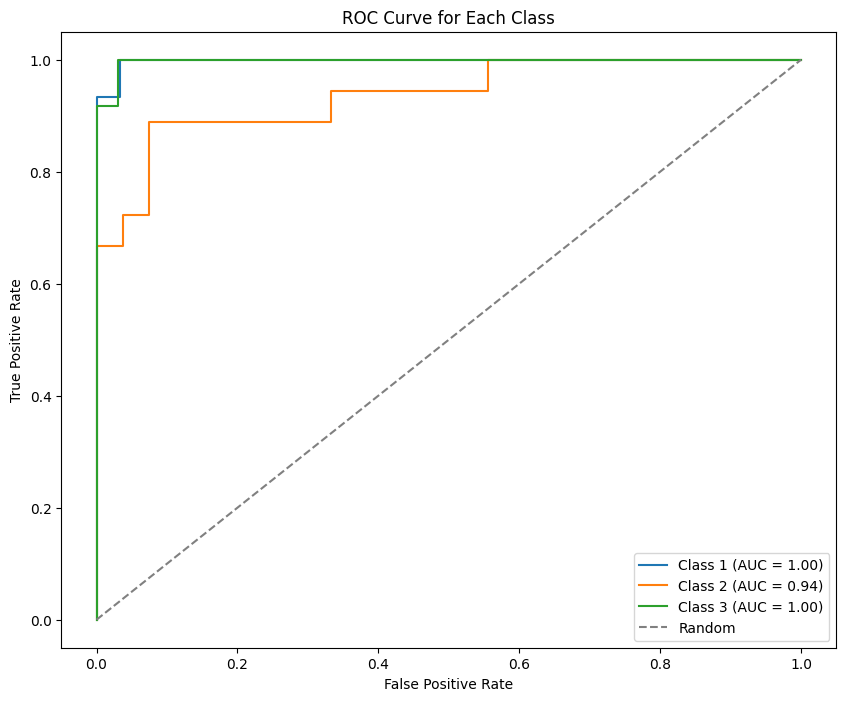

In [124]:
ROC_AUC(y_test,  class_probabilities, unique_classes)

### **可以看出AUC的值都较大。这与测试集较小有关系。若把训练集和测试集的比例调为1：1，则AUC的值会变小，且曲线也会有更多阶梯**

### **拓展要求**

<font size=3>
    
ROC曲线和AUC值是常用于评价分类模型性能的指标，尤其适用于二分类问题。以下是它们作为分类评价指标的合理性的浅谈：

一、ROC曲线的合理性：

①不受类别不平衡影响： ROC曲线对于类别不平衡的数据集具有鲁棒性。在类别不平衡的情况下，某些指标（如精度）可能不够敏感，而ROC曲线能够更全面地反映模型在正负类别上的表现。

②可视化分类器性能： ROC曲线提供了一种直观的方式来可视化分类器在不同阈值下的性能表现。曲线越靠近左上角，说明模型的性能越好。

③对阈值敏感度的分析： ROC曲线帮助理解分类器在不同阈值下的表现，从而更好地理解模型在不同工作点上的权衡。

二、AUC值的合理性：

①单一数值概括性能： AUC值提供了一个单一的数值，用于总结ROC曲线下的整体性能。这有助于简化模型比较和选择的过程。

②类别不平衡下的稳健性： AUC值对于类别不平衡数据集更为稳健，不会受到数据集中正负样本比例的影响。

③随机模型的比较基准： AUC值为随机猜测的模型提供了基准值0.5，因此AUC值越接近1，模型性能越好。

三、注意事项：

①对于多类别问题的变体： 对于多类别问题，ROC曲线和AUC值的使用可能需要结合多类别的评估方法，如微平均和宏平均。

②对业务问题的理解： 评价指标的选择应该基于具体业务问题和对模型性能的关注点。ROC曲线和AUC值适用于某些情境，但并非对所有问题都是最合适的。

综合而言，ROC曲线和AUC值是分类器性能评价的有力工具，尤其适用于二分类问题，但在使用时仍需结合具体的业务场景和问题要求。

</font>